In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from portfolio_optimisation import calc_returns_cov, optimize_portfolio 
from utils import load_and_prepare_data, preprocess_financial_data, cap_inf

import warnings
warnings.filterwarnings('ignore')

In [103]:
def standardize_metrics(latest, metrics, financial_data):
    standardized_data = latest.copy()
    mean_values = financial_data[metrics].mean()
    std_dev_values = financial_data[metrics].std()
    for metric in metrics:
        standardized_data[metric] = (standardized_data[metric] - mean_values[metric]) / std_dev_values[metric]
    return standardized_data[metrics].values

def calc_weighted_scores(latest, standardized_values, causal_estimates):
    weighted_scores = standardized_values.dot(causal_estimates)
    latest['weighted_score'] = weighted_scores
    return latest[['ticker', 'weighted_score', 'date']].sort_values('weighted_score', ascending=False).reset_index(drop=True)

def get_causal_study_ticker_weights(prediction):
    return dict(zip(prediction.ticker, prediction.weighted_score / prediction.weighted_score.abs().sum()))

def calc_cumulative_return(group, weights):
    group = group.sort_values('date_x')
    group['weighted_return'] = group['return'] * weights[group['ticker'].iloc[0]]
    return group

def plot_cumulative_returns(result, portfolio_cumulative_return):
    """Plot cumulative returns for each ticker and the portfolio."""

    sns.set_theme(style="whitegrid")
    colors = sns.color_palette("tab10", n_colors=len(result['ticker'].unique()))
    ticker_colors = dict(zip(result['ticker'].unique(), colors))

    plt.figure(figsize=(18, 12))

    for ticker in result['ticker'].unique():
        subset = result[result['ticker'] == ticker]
        plt.plot(subset['date_x'], (1 + subset['return']).cumprod() - 1, alpha=0.5,
                label=ticker, color=ticker_colors[ticker], linestyle='--', linewidth=1)

    plt.plot(portfolio_cumulative_return, label="Portfolio", color="green", linestyle='-', linewidth=3, marker='s', markersize=2)
    
    plt.title('Weighted Cumulative Returns from 2024 Q1 Onwards', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Return', fontsize=14)
    plt.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def portfolio_performance(stock_prices, optimal_weights, prediction, risk_free_rate, plot=True):
    optimal_weights_dict = dict(zip(prediction['ticker'], optimal_weights))
    portfolio = pd.merge(stock_prices[['date', 'ticker', 'return']], prediction, on='ticker')

    filtered_portfolio = portfolio[(portfolio['date_x'] >= pd.Timestamp('2024-03-31'))] # 2024 Q1
    result = filtered_portfolio.groupby('ticker').apply(
        calc_cumulative_return, weights=optimal_weights_dict).reset_index(drop=True)

    portfolio_daily_return = result.groupby('date_x')['weighted_return'].sum()
    portfolio_cumulative_return = (1 + portfolio_daily_return).cumprod() - 1

    excess_daily_return = portfolio_daily_return - risk_free_rate / 252  # Assuming 252 trading days in a year
    sharpe_ratio = np.mean(excess_daily_return) / np.std(excess_daily_return) * np.sqrt(252)

    if plot:
        print(f'From 2024 Realized Sharpe Ratio: {sharpe_ratio:.2f}')
        plot_cumulative_returns(result, portfolio_cumulative_return)
        return None
    return sharpe_ratio


In [104]:
balance_sheet_path = './DOW30_balance_sheet.csv'
cash_flow_path = './DOW30_cash_flow.csv'
income_statement_path = './DOW30_income_statement.csv'
stock_prices_path = './DOW30.csv'
DOW30_2010 = pd.read_csv('./technicals/DOW30.csv')
causal_result = pd.read_csv('./CausalData/study_result.csv')

# financial report data
balance_sheet, cash_flow, income_statement, stock_prices = load_and_prepare_data(
    balance_sheet_path, cash_flow_path, income_statement_path, stock_prices_path)

financial_data = preprocess_financial_data(balance_sheet, cash_flow, income_statement)
financial_data = cap_inf(financial_data)

# latest data avail to build a portfolio
latest = financial_data[(financial_data.year == 2024) & (financial_data.quarter == 1)]
tickers = latest.ticker.tolist()

# historical data for sharpe
expected_returns, cov_matrix = calc_returns_cov(DOW30_2010, tickers)

# causal study result
top_factors = causal_result[['metric_name', 'causal_estimate']].sort_values(by='causal_estimate', key=abs, ascending=False)
metrics = top_factors['metric_name'].tolist()
causal_estimates = top_factors['causal_estimate'].values
standardized_values = standardize_metrics(latest, metrics, financial_data)
prediction = calc_weighted_scores(latest, standardized_values, causal_estimates)
ticker_weights = get_causal_study_ticker_weights(prediction)

In [105]:
risk_free_rate = 0.04

In [106]:
prediction # 2024 Q1 report

,ticker,weighted_score,date
0,AAPL,6.072796,2023-12-30
1,MSFT,3.460632,2023-09-30
2,WMT,3.232296,2024-04-30
3,VZ,1.117377,2024-03-31
4,CVX,0.750776,2024-03-31
5,GS,0.659671,2024-03-31
6,INTC,0.540949,2024-03-30
7,CSCO,-0.043081,2023-10-28
8,HD,-0.145910,2024-04-28
9,KO,-0.271886,2024-03-29


In [107]:
ticker_weights # purely based on causal study

{'AAPL': 0.18026920219187964,
 'MSFT': 0.10272785879346265,
 'WMT': 0.0959497780356334,
 'VZ': 0.033169011888606485,
 'CVX': 0.02228655682685716,
 'GS': 0.019582152264268297,
 'INTC': 0.016057904566747643,
 'CSCO': -0.0012788461346269224,
 'HD': -0.004331281690554151,
 'KO': -0.008070850997014017,
 'DIS': -0.009356638792002617,
 'MRK': -0.011105195973723881,
 'PG': -0.013180207528677683,
 'NKE': -0.016788483695914395,
 'JNJ': -0.017752355421831442,
 'WBA': -0.018035825044324178,
 'UNH': -0.01823505582889258,
 'V': -0.02437873206786051,
 'CRM': -0.028621975464410872,
 'AXP': -0.028789532474506857,
 'DOW': -0.02986352280030735,
 'CAT': -0.032295100665046504,
 'AMGN': -0.0334212689897732,
 'MCD': -0.03404918052163111,
 'MMM': -0.03719509142913691,
 'HON': -0.03732360418474095,
 'TRV': -0.04099691813947341,
 'BA': -0.04206685086436733,
 'IBM': -0.04282101672372778}

In [108]:
weighted_scores = list(ticker_weights.values())

From 2010 Historical Sharpe Ratio : 0.66
From 2024 Realized Sharpe Ratio: 1.98


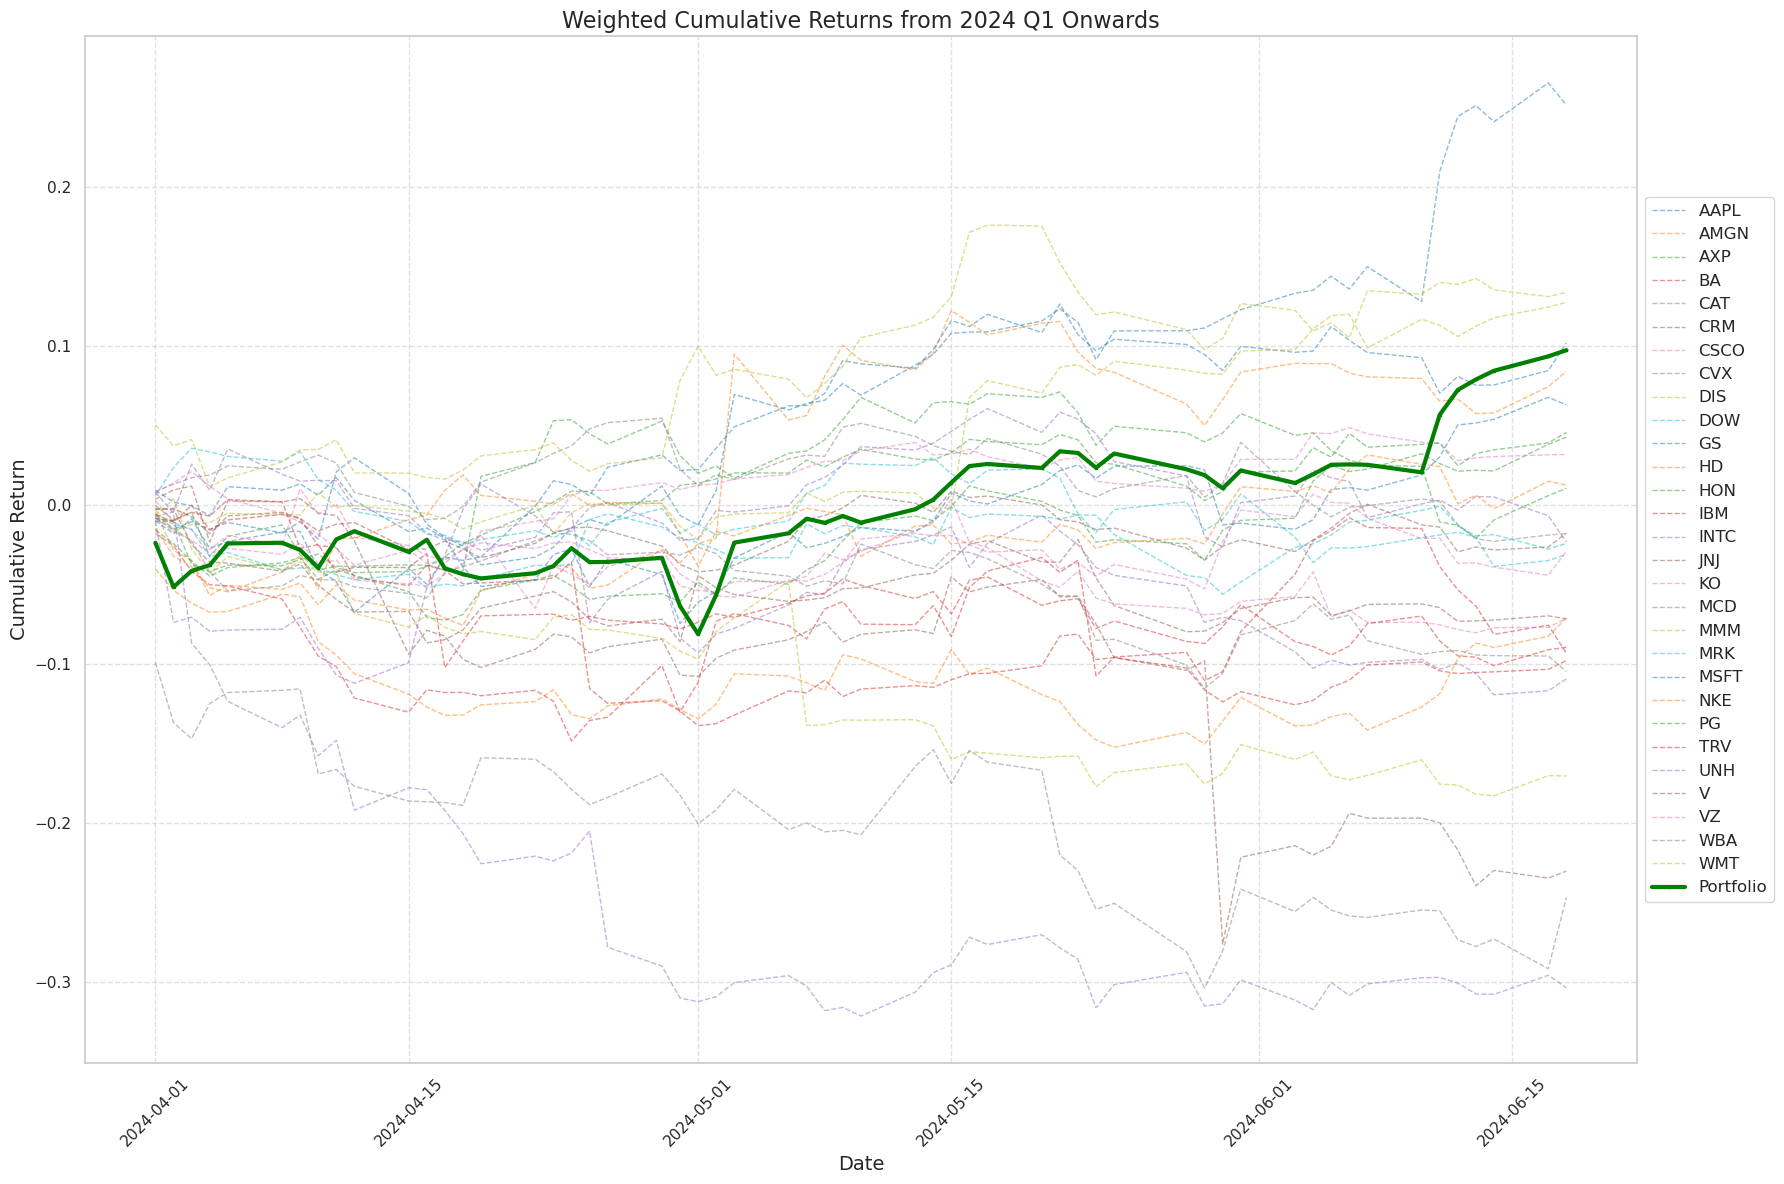

In [109]:
delta = 0  # coefficient for Sharpe
gamma = 1  # coefficient for causal study factors

# purely based on studied factors but constraint on historical risk
# delta = 0 violates the mean variance optimisation so historical Sharpe is expected to be low
# will find optimal gamma later

optimal_weights, *_, sharpe_ratio = optimize_portfolio(
    expected_returns,
    cov_matrix,
    weighted_scores,
    delta=delta,
    gamma=gamma,
    target_risk=0.2,
    risk_free_rate=risk_free_rate
)

print(f'From 2010 Historical Sharpe Ratio : {sharpe_ratio:.2f}')
portfolio_performance(stock_prices, optimal_weights, prediction, risk_free_rate=risk_free_rate)

From 2010 Historical Sharpe Ratio : 1.54
From 2024 Realized Sharpe Ratio: 2.89


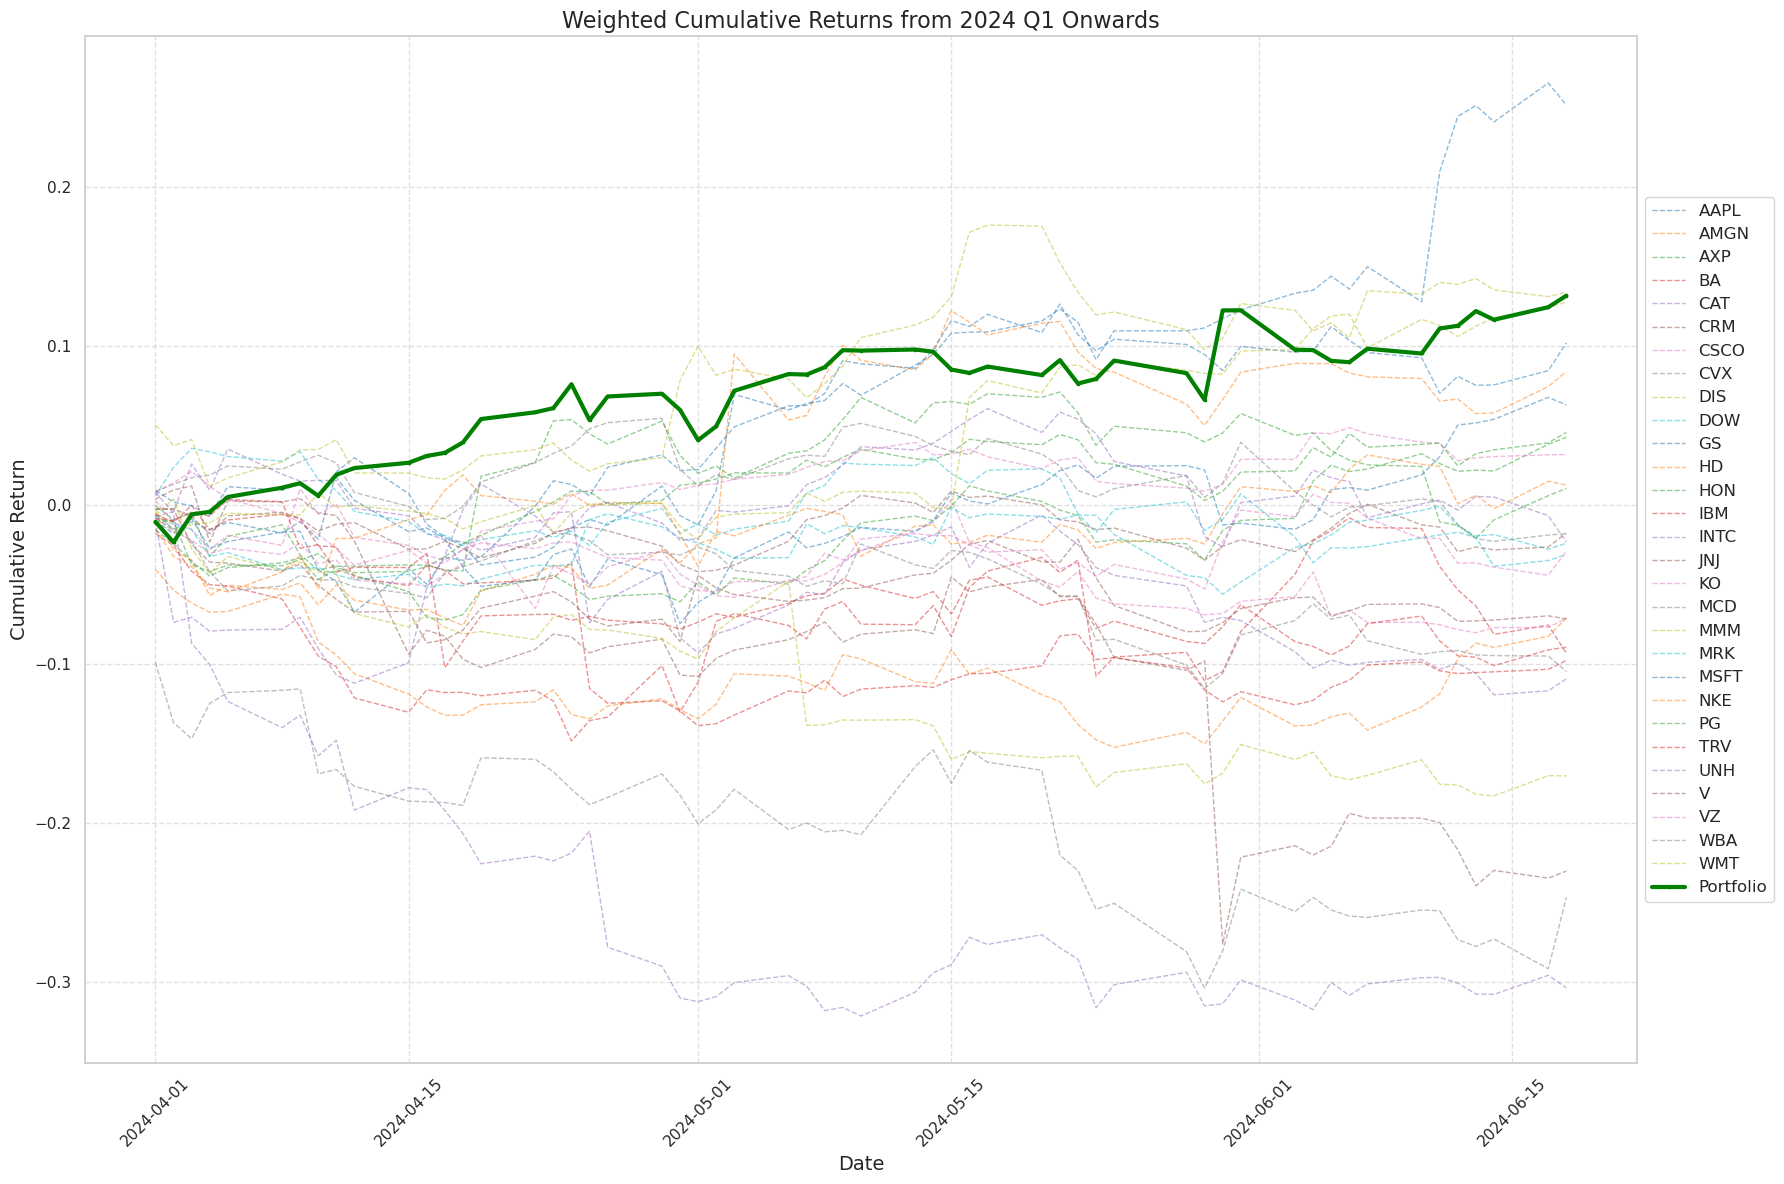

In [110]:
delta = 1  # coefficient for Sharpe
gamma = 0  # coefficient for causal study factors

# only use Sharpe

optimal_weights, *_, sharpe_ratio = optimize_portfolio(
    expected_returns,
    cov_matrix,
    weighted_scores,
    delta=delta,
    gamma=gamma,
    target_risk=0.2,
    risk_free_rate=risk_free_rate
)

print(f'From 2010 Historical Sharpe Ratio : {sharpe_ratio:.2f}')
portfolio_performance(stock_prices, optimal_weights, prediction, risk_free_rate=risk_free_rate)

From 2010 Historical Sharpe Ratio : 1.92
From 2024 Realized Sharpe Ratio: 5.53


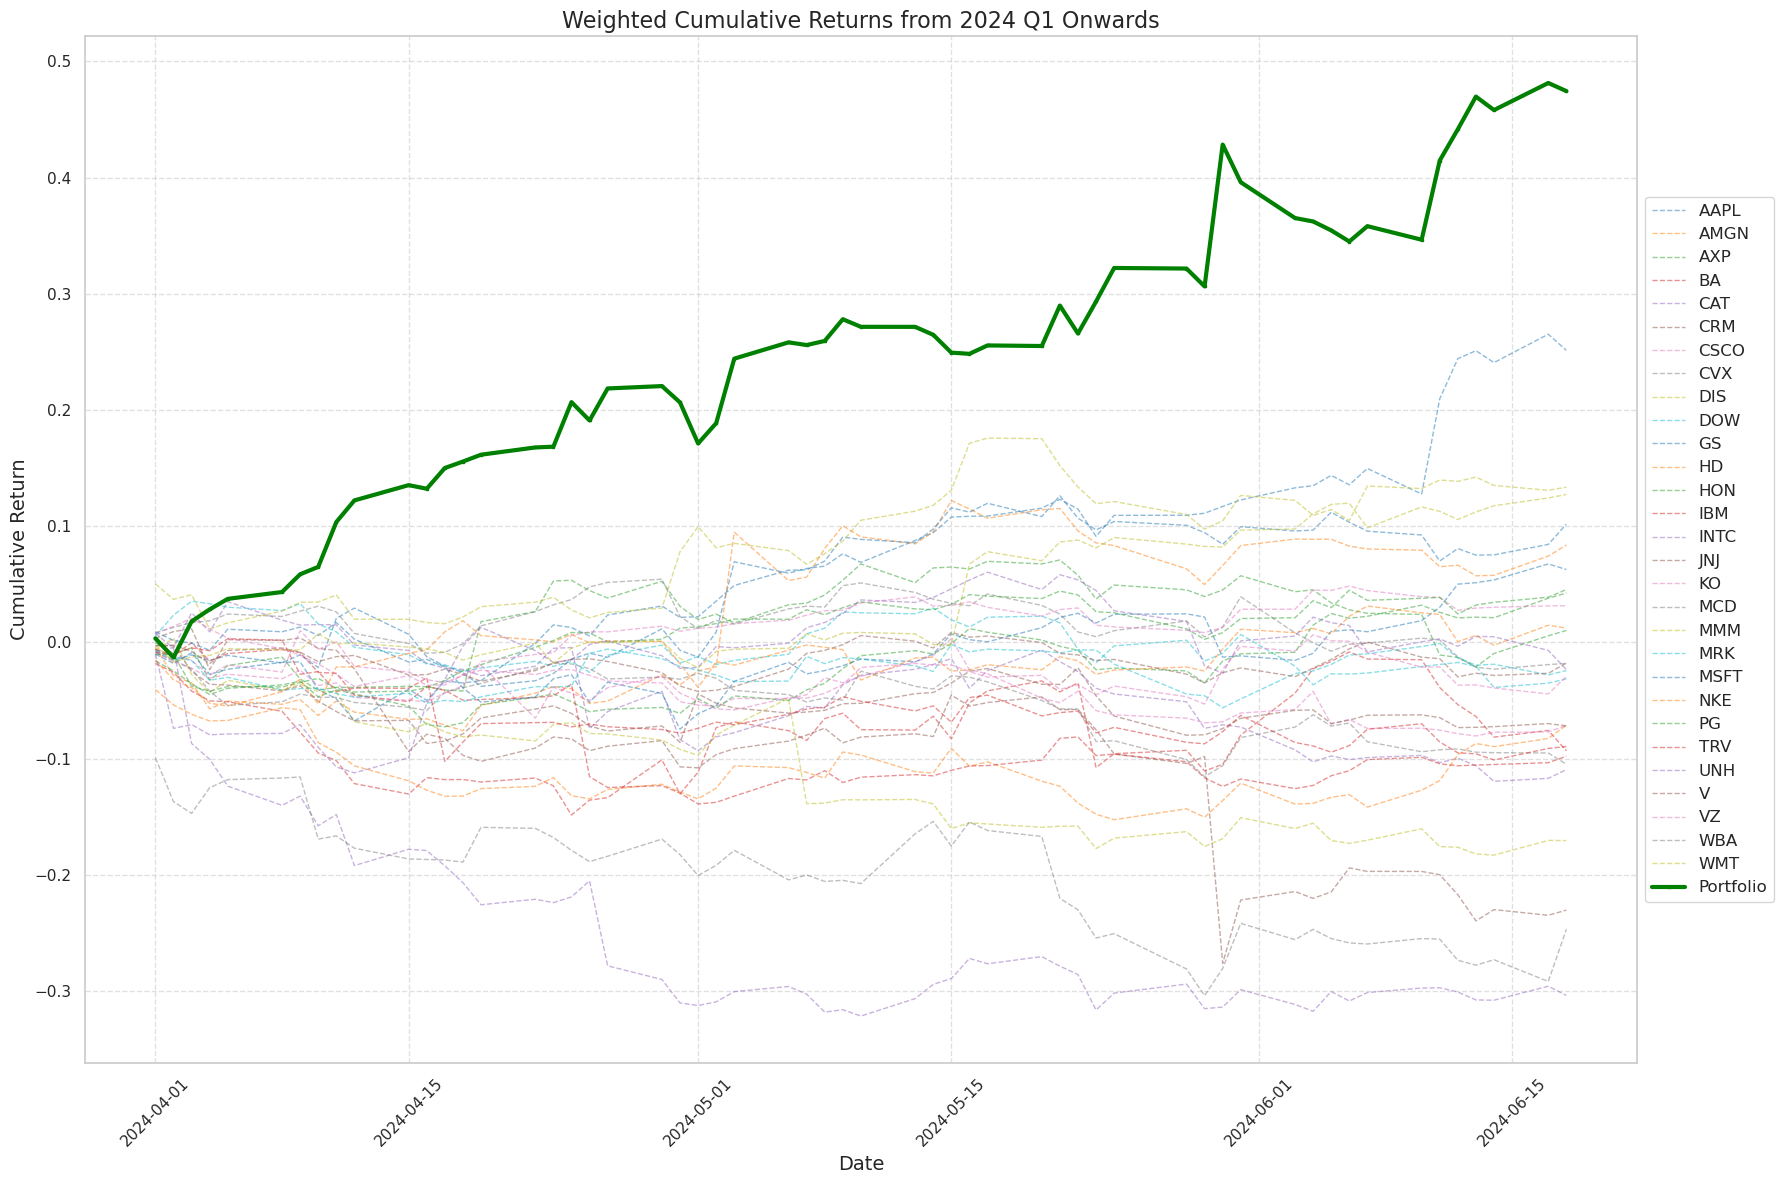

In [111]:
# combo
delta = 1
gamma = 1  

optimal_weights, *_, sharpe_ratio = optimize_portfolio(
    expected_returns,
    cov_matrix,
    weighted_scores,
    delta=delta,
    gamma=gamma,
    target_risk=0.3,
    risk_free_rate=risk_free_rate
)

print(f'From 2010 Historical Sharpe Ratio : {sharpe_ratio:.2f}')
portfolio_performance(stock_prices, optimal_weights, prediction, risk_free_rate=risk_free_rate)

In [112]:
def find_optimal_gamma(expected_returns, cov_matrix, weighted_scores, target_risk, risk_free_rate):
    delta = 1
    
    best_weights = None
    result = {'best_sharpe_ratio': -np.inf}

    gamma_range = np.linspace(0., 10.0, 50) 
    
    for gamma in gamma_range:
        weights, *_, historical_sharpe_ratio = optimize_portfolio(
            expected_returns, cov_matrix, weighted_scores, delta, gamma, target_risk, risk_free_rate
        )
        sharpe_ratio = portfolio_performance(stock_prices, weights, prediction, risk_free_rate, plot=False)
        if sharpe_ratio > result['best_sharpe_ratio']:
            result['best_sharpe_ratio'] = sharpe_ratio
            result['best_gamma'] = gamma
            result['historical_sharpe_ratio'] = historical_sharpe_ratio
            best_weights = weights
    return result, best_weights

In [113]:
result2, w2 = find_optimal_gamma(expected_returns, cov_matrix, weighted_scores, target_risk=0.2, risk_free_rate=risk_free_rate)

In [114]:
result2

{'best_sharpe_ratio': 3.8053950341610867,
 'best_gamma': 5.1020408163265305,
 'historical_sharpe_ratio': 1.38670443972277}

From 2024 Realized Sharpe Ratio: 3.81


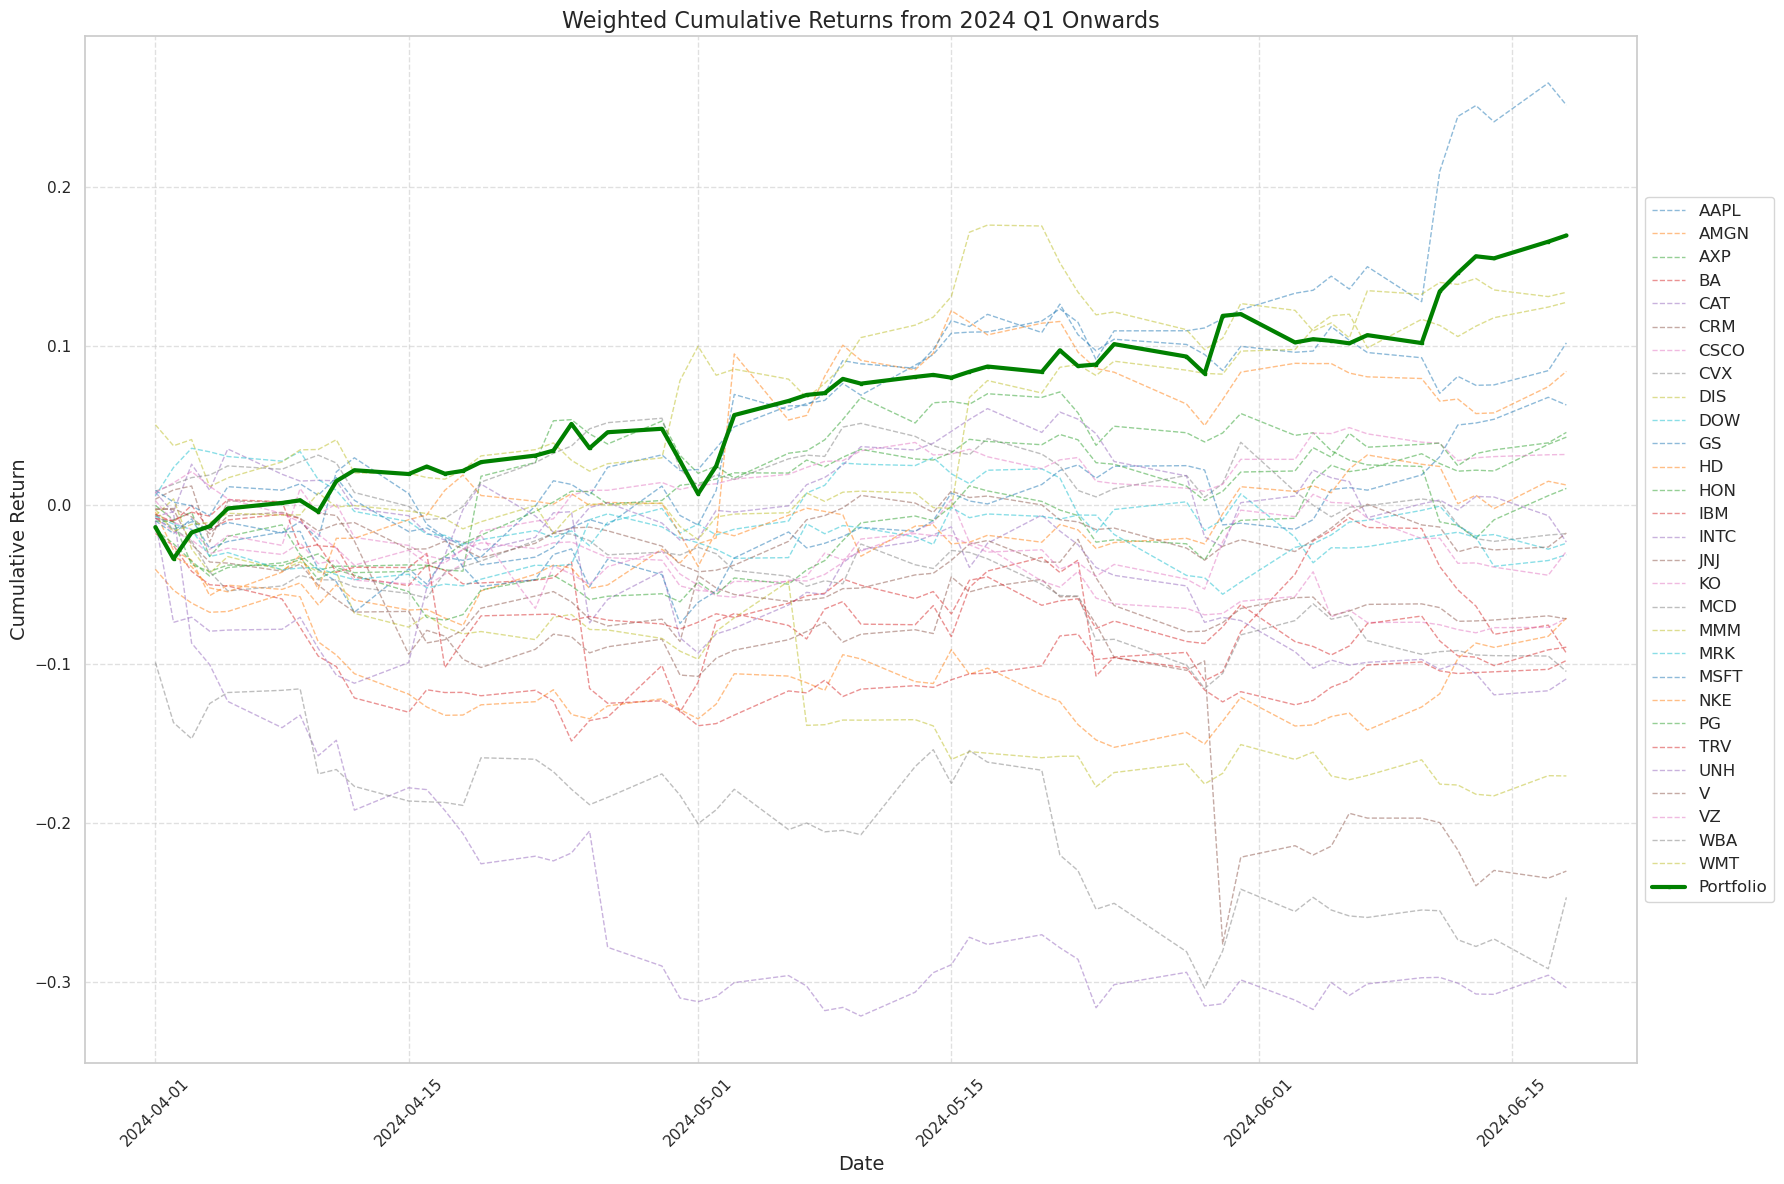

In [115]:
portfolio_performance(stock_prices, w2, prediction, risk_free_rate=risk_free_rate)

In [116]:
result3, w3 = find_optimal_gamma(expected_returns, cov_matrix, weighted_scores, target_risk=0.3, risk_free_rate=risk_free_rate)

In [117]:
result3

{'best_sharpe_ratio': 5.960440900084706,
 'best_gamma': 3.4693877551020407,
 'historical_sharpe_ratio': 1.7358478857114805}

From 2024 Realized Sharpe Ratio: 5.96


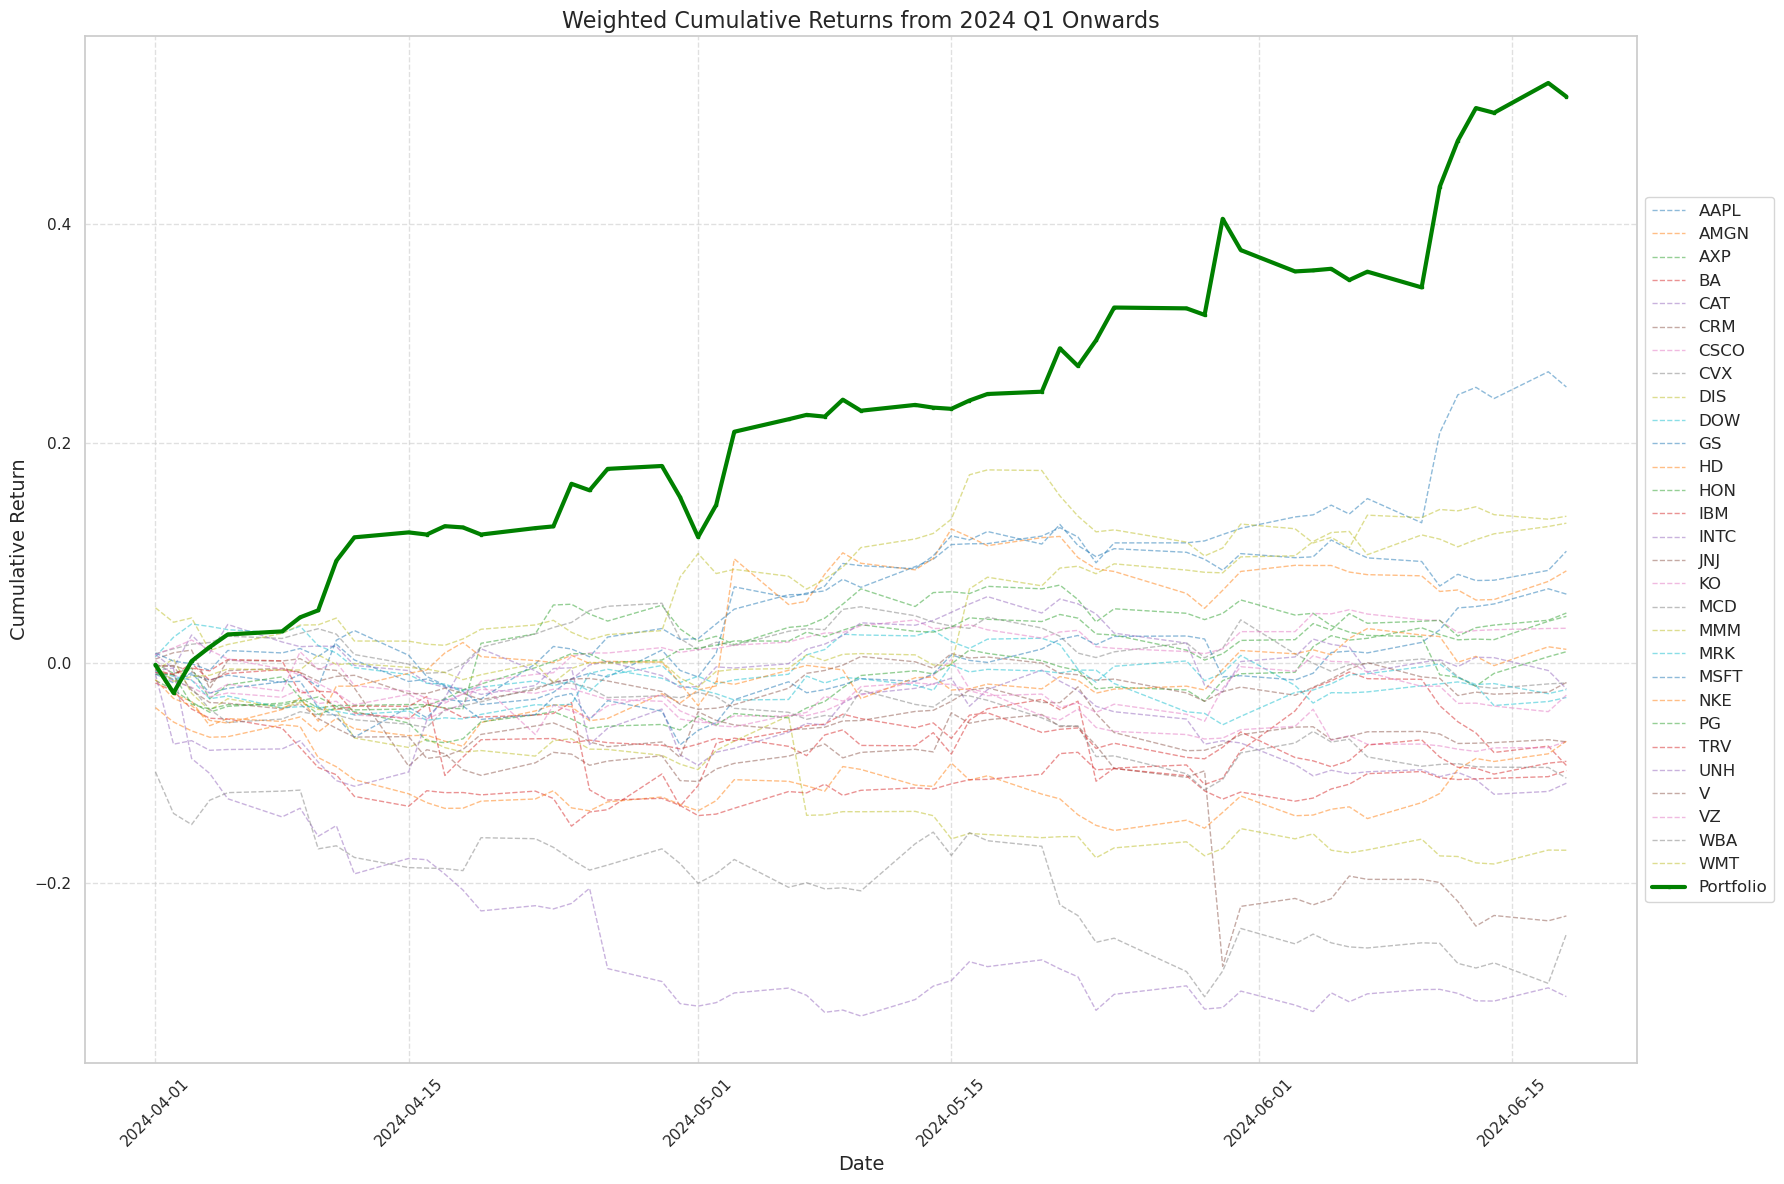

In [118]:
portfolio_performance(stock_prices, w3, prediction, risk_free_rate=risk_free_rate)